In [2]:
import pennylane as qml
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import pandas as pd
import argparse
import os
import math
import datetime
import time

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch

from solver import Solver
from data_loader import get_loader
from torch.backends import cudnn
from utils import *
from models import Generator, Discriminator
from data.sparse_molecular_dataset import SparseMolecularDataset
from rdkit import Chem

def str2bool(v):
    return v.lower() in ('true')

In [3]:
parser = argparse.ArgumentParser()

# Model configuration.
parser.add_argument('--z_dim', type=int, default=5, help='dimension of domain labels')
parser.add_argument('--g_conv_dim', default=[128,512], help='number of conv filters in the first layer of G')
parser.add_argument('--d_conv_dim', type=int, default=[[128, 64], 128, [128, 64]], help='number of conv filters in the first layer of D')
parser.add_argument('--g_repeat_num', type=int, default=6, help='number of residual blocks in G')
parser.add_argument('--d_repeat_num', type=int, default=6, help='number of strided conv layers in D')
parser.add_argument('--lambda_cls', type=float, default=1, help='weight for domain classification loss')
parser.add_argument('--lambda_rec', type=float, default=10, help='weight for reconstruction loss')
parser.add_argument('--lambda_gp', type=float, default=10, help='weight for gradient penalty')
parser.add_argument('--post_method', type=str, default='softmax', choices=['softmax', 'soft_gumbel', 'hard_gumbel'])

# Training configuration.
parser.add_argument('--batch_size', type=int, default=128, help='mini-batch size')
parser.add_argument('--num_iters', type=int, default=10000, help='number of total iterations for training D')
parser.add_argument('--num_iters_decay', type=int, default=5000, help='number of iterations for decaying lr')
parser.add_argument('--g_lr', type=float, default=0.0001, help='learning rate for G')
parser.add_argument('--d_lr', type=float, default=0.0001, help='learning rate for D')
parser.add_argument('--dropout', type=float, default=0., help='dropout rate')
parser.add_argument('--n_critic', type=int, default=5, help='number of D updates per each G update')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for Adam optimizer')
parser.add_argument('--beta2', type=float, default=0.999, help='beta2 for Adam optimizer')
parser.add_argument('--resume_iters', type=int, default=None, help='resume training from this step')

# Test configuration.
parser.add_argument('--test_iters', type=int, default=10000, help='test model from this step')

# Miscellaneous.
parser.add_argument('--num_workers', type=int, default=1)
parser.add_argument('--mode', type=str, default='test', choices=['train', 'test'])
parser.add_argument('--use_tensorboard', type=str2bool, default=False)

# Directories.
parser.add_argument('--mol_data_dir', type=str, default='data/gdb9_9nodes.sparsedataset')
parser.add_argument('--log_dir', type=str, default='molgan/logs')
parser.add_argument('--model_save_dir', type=str, default='molgan/models')
parser.add_argument('--sample_dir', type=str, default='molgan/samples')
parser.add_argument('--result_dir', type=str, default='molgan/results')

# Step size.
parser.add_argument('--log_step', type=int, default=10)
parser.add_argument('--sample_step', type=int, default=1000)
parser.add_argument('--model_save_step', type=int, default=10000)
parser.add_argument('--lr_update_step', type=int, default=1000)

config = parser.parse_known_args()[0]
print(config)

# For fast training.
cudnn.benchmark = True

Namespace(batch_size=128, beta1=0.5, beta2=0.999, d_conv_dim=[[128, 64], 128, [128, 64]], d_lr=0.0001, d_repeat_num=6, dropout=0.0, g_conv_dim=[128, 512], g_lr=0.0001, g_repeat_num=6, lambda_cls=1, lambda_gp=10, lambda_rec=10, log_dir='molgan/logs', log_step=10, lr_update_step=1000, mode='test', model_save_dir='molgan/models', model_save_step=10000, mol_data_dir='data/gdb9_9nodes.sparsedataset', n_critic=5, num_iters=10000, num_iters_decay=5000, num_workers=1, post_method='softmax', result_dir='molgan/results', resume_iters=None, sample_dir='molgan/samples', sample_step=1000, test_iters=10000, use_tensorboard=False, z_dim=5)


In [13]:
cuda = True if torch.cuda.is_available() else False

dev = qml.device('default.qubit', wires=5)
@qml.qnode(dev, interface='torch')
def gen_circuit(w):
    # random noise as generator input
    z = random.uniform(-1, 1)
    layers = 1
    qubits = 5
    cnt = 0
    
    # construct generator circuit for both atom vector and node matrix
    for i in range(qubits):
        qml.RY(np.arcsin(z), wires=i)
        qml.RZ(np.arccos(z), wires=i)
    for l in range(layers):
        for i in range(qubits):
            qml.RY(w[i], wires=i)
            qml.Hadamard(wires=i)
            cnt += 1
        for i in range(qubits-1):
            qml.CNOT(wires=[i, i+1])
            qml.RZ(w[i+qubits], wires=i+1)
            qml.CNOT(wires=[i, i+1])
            cnt += 1
    for i in range(qubits):
        qml.Hadamard(wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

In [14]:
w = torch.tensor(list(np.random.rand(9)*2-1), requires_grad=True)
gen_circuit(w)

tensor([0.9232, 0.8548, 0.4586, 0.9204, 0.8298], dtype=torch.float64,
       grad_fn=<_TorchQNodeBackward>)

In [15]:
self = Solver(config)

Generator(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=True)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.0, inplace=True)
  )
  (edges_layer): Linear(in_features=512, out_features=405, bias=True)
  (nodes_layer): Linear(in_features=512, out_features=45, bias=True)
  (dropoout): Dropout(p=0.0, inplace=False)
)
G
The number of parameters: 297666
Discriminator(
  (gcn_layer): GraphConvolution(
    (linear1): Linear(in_features=5, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (agg_layer): GraphAggregation(
    (sigmoid_linear): Sequential(
      (0): Linear(in_features=69, out_features=128, bias=True)
      (1): Sigmoid()
    )
    (tanh_linear): Sequential(
      (0): Linear(in_features=69, out_features=128, bias=True)
      (1): Tanh()
    )
    (d

In [16]:
# Learning rate cache for decaying.
g_lr = self.g_lr
d_lr = self.d_lr
gen_weights = torch.tensor(list(np.random.rand(9)*2-1), requires_grad=True)
self.g_optimizer = torch.optim.Adam(list(self.G.parameters())+list(self.V.parameters())+[gen_weights],
                                    self.g_lr, [self.beta1, self.beta2])
self.d_optimizer = torch.optim.Adam(self.D.parameters(), self.d_lr, [self.beta1, self.beta2])

# Start training.
print('Start training...')
start_time = time.time()
cnt = 0
for i in range(3):#self.num_iters
    print(gen_weights)
    cnt += 1
    if (i+1) % self.log_step == 0:
        mols, _, _, a, x, _, _, _, _ = self.data.next_validation_batch()
        z = self.sample_z(a.shape[0])
        print('[Valid]', '')
    else:
        mols, _, _, a, x, _, _, _, _ = self.data.next_train_batch(self.batch_size)
        

        # =================================================================================== #
        #                             1. Preprocess input data                                #
        # =================================================================================== #

        a = torch.from_numpy(a).to(self.device).long()            # Adjacency.
        x = torch.from_numpy(x).to(self.device).long()            # Nodes.
        a_tensor = self.label2onehot(a, self.b_dim)
        x_tensor = self.label2onehot(x, self.m_dim)
        sample_list = [gen_circuit(gen_weights) for i in range(self.batch_size)]
        z = torch.stack(tuple(sample_list)).to(self.device).float()
        
        self.d_optimizer.zero_grad()
        logits_real, features_real = self.D(a_tensor, None, x_tensor)
        d_loss_real = - torch.mean(logits_real)

        # Compute loss with fake images.
        edges_logits, nodes_logits = self.G(z)
        # Postprocess with Gumbel softmax
        (edges_hat, nodes_hat) = self.postprocess((edges_logits, nodes_logits), self.post_method)
        logits_fake, features_fake = self.D(edges_hat, None, nodes_hat)
        d_loss_fake = torch.mean(logits_fake)

        # Compute loss for gradient penalty.
        eps = torch.rand(logits_real.size(0),1,1,1).to(self.device)
        x_int0 = (eps * a_tensor + (1. - eps) * edges_hat).requires_grad_(True)
        x_int1 = (eps.squeeze(-1) * x_tensor + (1. - eps.squeeze(-1)) * nodes_hat).requires_grad_(True)
        grad0, grad1 = self.D(x_int0, None, x_int1)
        d_loss_gp = self.gradient_penalty(grad0, x_int0) + self.gradient_penalty(grad1, x_int1)

        # Backward and optimize.
        d_loss = d_loss_fake + d_loss_real + self.lambda_gp * d_loss_gp
        d_loss.backward(retain_graph=True)
        self.d_optimizer.step()
        
        # Generator
        self.g_optimizer.zero_grad()
        edges_logits, nodes_logits = self.G(z)
        # Postprocess with Gumbel softmax
        (edges_hat, nodes_hat) = self.postprocess((edges_logits, nodes_logits), self.post_method)
        logits_fake, features_fake = self.D(edges_hat, None, nodes_hat)
        g_loss_fake = - torch.mean(logits_fake)

        # Backward and optimize.
        g_loss = g_loss_fake
        g_loss.backward(retain_graph=True)
        self.g_optimizer.step()

Start training...
tensor([ 0.9225,  0.9951,  0.8398,  0.1180,  0.5133, -0.3677, -0.5545,  0.2099,
         0.3869], dtype=torch.float64, requires_grad=True)


KeyboardInterrupt: 

In [5]:
# Learning rate cache for decaying.
g_lr = self.g_lr
d_lr = self.d_lr
gen_weights = torch.tensor(list(np.random.rand(9)*2-1), requires_grad=True)
self.g_optimizer = torch.optim.Adam(list(self.G.parameters())+list(self.V.parameters())+[gen_weights],
                                    self.g_lr, [self.beta1, self.beta2])
self.d_optimizer = torch.optim.Adam(self.D.parameters(), self.d_lr, [self.beta1, self.beta2]) #+[gen_weights]

# Start training from scratch or resume training.
start_iters = 0
self.resume_iters = 0
if self.resume_iters:
    start_iters = self.resume_iters
    self.restore_model(self.resume_iters)
    
# Start training.
print('Start training...')
start_time = time.time()

for i in range(1000): #self.num_iters
    if (i+1) % self.log_step == 0:
        mols, _, _, a, x, _, _, _, _ = self.data.next_validation_batch()
        z = self.sample_z(a.shape[0])
        print('[Valid]', '')
    else:
        mols, _, _, a, x, _, _, _, _ = self.data.next_train_batch(self.batch_size)
        

        # =================================================================================== #
        #                             1. Preprocess input data                                #
        # =================================================================================== #

        a = torch.from_numpy(a).to(self.device).long()            # Adjacency.
        x = torch.from_numpy(x).to(self.device).long()            # Nodes.
        a_tensor = self.label2onehot(a, self.b_dim)
        x_tensor = self.label2onehot(x, self.m_dim)
        sample_list = [gen_circuit(gen_weights) for i in range(self.batch_size)]
        z = torch.stack(tuple(sample_list)).to(self.device).float()
#         z = self.sample_z(self.batch_size)
#         z = torch.from_numpy(z).to(self.device).float()

        # =================================================================================== #
        #                             2. Train the discriminator                              #
        # =================================================================================== #

        # Compute loss with real images.
        logits_real, features_real = self.D(a_tensor, None, x_tensor)
        d_loss_real = - torch.mean(logits_real)

        # Compute loss with fake images.
        edges_logits, nodes_logits = self.G(z)
        # Postprocess with Gumbel softmax
        (edges_hat, nodes_hat) = self.postprocess((edges_logits, nodes_logits), self.post_method)
        logits_fake, features_fake = self.D(edges_hat, None, nodes_hat)
        d_loss_fake = torch.mean(logits_fake)

        # Compute loss for gradient penalty.
        eps = torch.rand(logits_real.size(0),1,1,1).to(self.device)
        x_int0 = (eps * a_tensor + (1. - eps) * edges_hat).requires_grad_(True)
        x_int1 = (eps.squeeze(-1) * x_tensor + (1. - eps.squeeze(-1)) * nodes_hat).requires_grad_(True)
        grad0, grad1 = self.D(x_int0, None, x_int1)
        d_loss_gp = self.gradient_penalty(grad0, x_int0) + self.gradient_penalty(grad1, x_int1)


        # Backward and optimize.
        d_loss = d_loss_fake + d_loss_real + self.lambda_gp * d_loss_gp
        self.reset_grad()
        d_loss.backward(retain_graph=True)
        self.d_optimizer.step()

        # =================================================================================== #
        #                               3. Train the generator                                #
        # =================================================================================== #

        if (i+1) % self.n_critic == 0 or True:
            # Z-to-target
            edges_logits, nodes_logits = self.G(z)
            # Postprocess with Gumbel softmax
            (edges_hat, nodes_hat) = self.postprocess((edges_logits, nodes_logits), self.post_method)
            logits_fake, features_fake = self.D(edges_hat, None, nodes_hat)
            g_loss_fake = - torch.mean(logits_fake)

            # Real Reward
            rewardR = torch.from_numpy(self.reward(mols)).to(self.device)
            # Fake Reward
            (edges_hard, nodes_hard) = self.postprocess((edges_logits, nodes_logits), 'hard_gumbel')
            edges_hard, nodes_hard = torch.max(edges_hard, -1)[1], torch.max(nodes_hard, -1)[1]
            mols = [self.data.matrices2mol(n_.data.cpu().numpy(), e_.data.cpu().numpy(), strict=True)
                    for e_, n_ in zip(edges_hard, nodes_hard)]
            rewardF = torch.from_numpy(self.reward(mols)).to(self.device)

            # Value loss
            value_logit_real,_ = self.V(a_tensor, None, x_tensor, torch.sigmoid)
            value_logit_fake,_ = self.V(edges_hat, None, nodes_hat, torch.sigmoid)
            g_loss_value = torch.mean((value_logit_real - rewardR) ** 2 + (
                                       value_logit_fake - rewardF) ** 2)
            
            # Backward and optimize.
            g_loss = g_loss_fake + g_loss_value
            self.reset_grad()
            g_loss.backward(retain_graph=True)
            self.g_optimizer.step()

        print(
            "%s\tEpoch %d/%d \t[D loss: %f]\t[G loss: %f]"
            % (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), i+1, self.num_iters, d_loss.item(), g_loss.item())
        )
        print(gen_weights.detach())

NameError: name 'self' is not defined

In [ ]:
gen_weights.detach().numpy()

In [ ]:
samples = []
num_samples = 1000
w = [1.8302, 2.1733, 4.2969] #[-23.1983,  -4.4826, -10.3598]
for i in range(num_samples):
    samples.append(gen_circuit(w))

In [ ]:
# the histogram of the data
plt.hist(samples, 30, facecolor='g', alpha=0.75)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of bimodal distribution')
plt.xlim(-1, 1)
plt.ylim(0, 140)
plt.grid(True)
plt.show()

In [4]:
import csv
read_data = []
with open('metric_scores.csv') as file:
    csv_reader = csv.reader(file, delimiter=',')
    next(csv_reader)
    for line in csv_reader:
        read_data.append(line)
        
logp = [eval(read_data[i][6]) for i in range(len(read_data)) if read_data[i][6]!= 'nan']
sa = [eval(read_data[i][7]) for i in range(len(read_data)) if read_data[i][7]!= 'nan']

d_loss = [eval(read_data[i][2]) for i in range(len(read_data))]
g_loss = [eval(read_data[i][3]) for i in range(len(read_data))]

Error: line contains NULL byte

In [47]:
len(g_loss)

18883

Text(0.5, 1.0, 'Hybrid GAN')

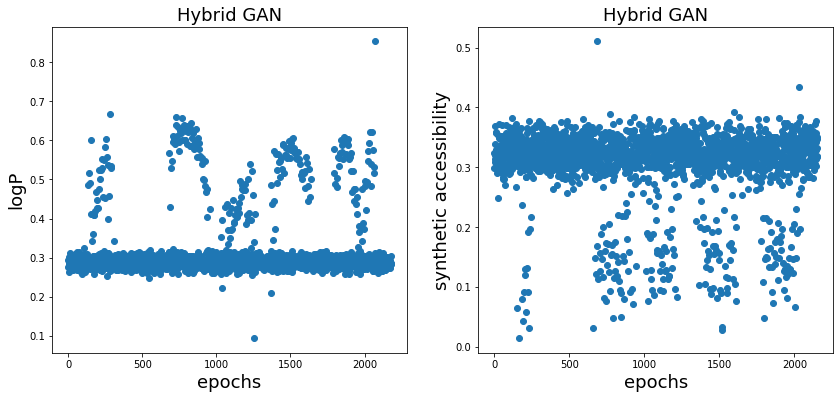

In [57]:
fig = plt.subplots(1, 2, figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(range(len(logp)), logp, marker='o')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('logP', fontsize=18)
plt.title('Hybrid GAN', fontsize=18)

plt.subplot(1, 2, 2)
plt.scatter(range(len(sa)), sa, marker='o')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('synthetic accessibility', fontsize=18)
plt.title('Hybrid GAN', fontsize=18)

In [56]:
len(sa)

17299

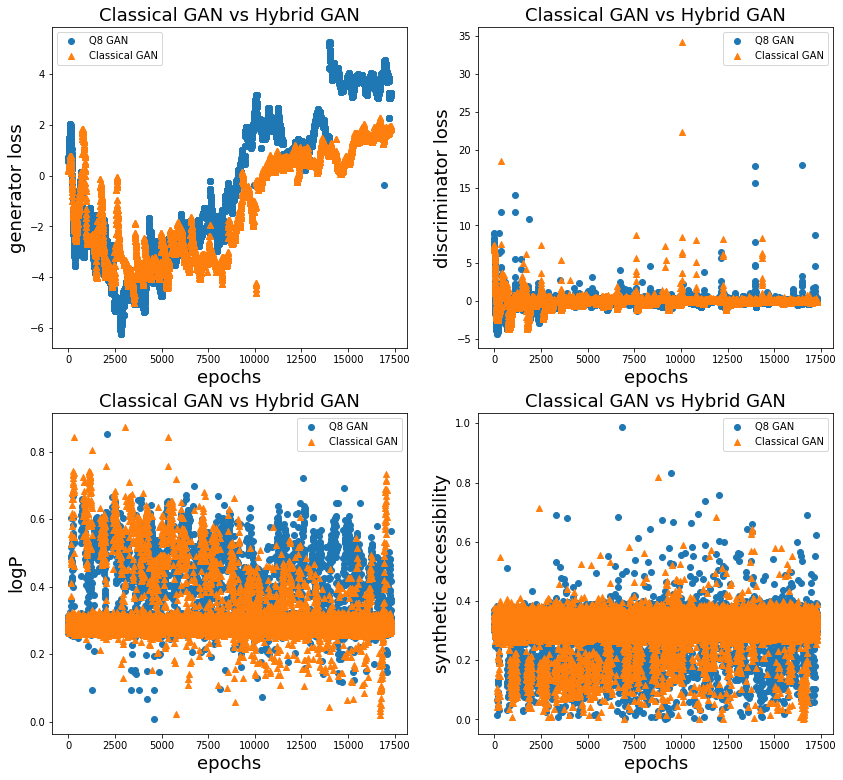

In [64]:
iters = 17299
fig = plt.subplots(2, 2, figsize=(14, 13))
plt.subplot(2, 2, 1)
plt.scatter(range(iters), g_loss[:iters], marker='o', label='Q8 GAN')
plt.scatter(range(iters), gan_g_loss[:iters], marker='^', label='Classical GAN')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('generator loss', fontsize=18)
plt.title('Classical GAN vs Hybrid GAN', fontsize=18)
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(range(iters), d_loss[:iters], marker='o', label='Q8 GAN')
plt.scatter(range(iters), gan_d_loss[:iters], marker='^', label='Classical GAN')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('discriminator loss', fontsize=18)
plt.title('Classical GAN vs Hybrid GAN', fontsize=18)
plt.legend()

plt.subplot(2, 2, 3)
plt.scatter(range(iters), logp[:iters], marker='o', label='Q8 GAN')
plt.scatter(range(iters), gan_logp[:iters], marker='^', label='Classical GAN')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('logP', fontsize=18)
plt.title('Classical GAN vs Hybrid GAN', fontsize=18)
plt.legend()

plt.subplot(2, 2, 4)
plt.scatter(range(iters), sa[:iters], marker='o', label='Q8 GAN')
plt.scatter(range(iters), gan_sa[:iters], marker='^', label='Classical GAN')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('synthetic accessibility', fontsize=18)
plt.title('Classical GAN vs Hybrid GAN', fontsize=18)
plt.legend()

In [49]:
import csv
read_data = []
with open('../MolGAN-pytorch/gan_metric_scores.csv') as file:
    csv_reader = csv.reader(file, delimiter=',')
    next(csv_reader)
    for line in csv_reader:
        read_data.append(line)
        
gan_logp = [eval(read_data[i][6]) for i in range(len(read_data)) if read_data[i][6]!= 'nan']
gan_sa = [eval(read_data[i][7]) for i in range(len(read_data)) if read_data[i][7]!= 'nan']

gan_d_loss = [eval(read_data[i][2]) for i in range(len(read_data))]
gan_g_loss = [eval(read_data[i][3]) for i in range(len(read_data))]

In [50]:
len(gan_d_loss)

23075

ValueError: x and y must be the same size

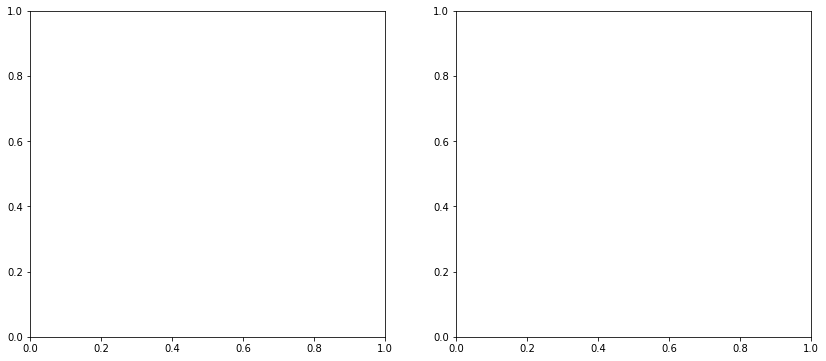

In [53]:
epoch = 18883
fig = plt.subplots(1, 2, figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(range(epoch), logp[:epoch], marker='o', label='Hybrid GAN')
plt.scatter(range(epoch), gan_logp[:epoch], marker='^', label='Classical GAN')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('logP', fontsize=18)
plt.title('Classical GAN vs Hybrid GAN', fontsize=18)
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(range(epoch), sa, marker='o', label='Hybrid GAN')
plt.scatter(range(epoch), gan_sa[:epoch], marker='^', label='Classical GAN')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('synthetic accessibility', fontsize=18)
plt.title('Classical GAN vs Hybrid GAN', fontsize=18)
plt.legend()

Text(0.5, 1.0, 'Classical GAN')

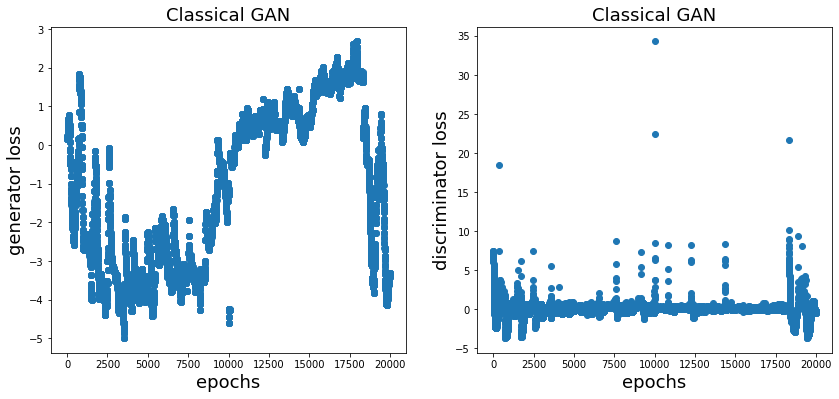

In [8]:
fig = plt.subplots(1, 2, figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(range(20000), gan_g_loss[:20000], marker='o')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('generator loss', fontsize=18)
plt.title('Classical GAN', fontsize=18)

plt.subplot(1, 2, 2)
plt.scatter(range(20000), gan_d_loss[:20000], marker='o')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('discriminator loss', fontsize=18)
plt.title('Classical GAN', fontsize=18)

In [39]:
# for 12 qubits
import csv
read_data = []
with open('metric_scores_12q.csv') as file:
    csv_reader = csv.reader(file, delimiter=',')
    next(csv_reader)
    for line in csv_reader:
        read_data.append(line)
        
gan_logp = [eval(read_data[i][10]) for i in range(len(read_data)) if read_data[i][10]!= 'nan']
gan_sa = [eval(read_data[i][11]) for i in range(len(read_data)) if read_data[i][11]!= 'nan']

q12_d_loss = [eval(read_data[i][2]) for i in range(len(read_data))]
q12_d_loss_fake = [eval(read_data[i][3]) for i in range(len(read_data))]
q12_d_loss_real = [eval(read_data[i][4]) for i in range(len(read_data))]
q12_g_loss = [eval(read_data[i][5]) for i in range(len(read_data))]
q12_g_loss_fake = [eval(read_data[i][6]) for i in range(len(read_data))]
q12_g_loss_value = [eval(read_data[i][7]) for i in range(len(read_data))]

In [40]:
len(q12_d_loss)

6619

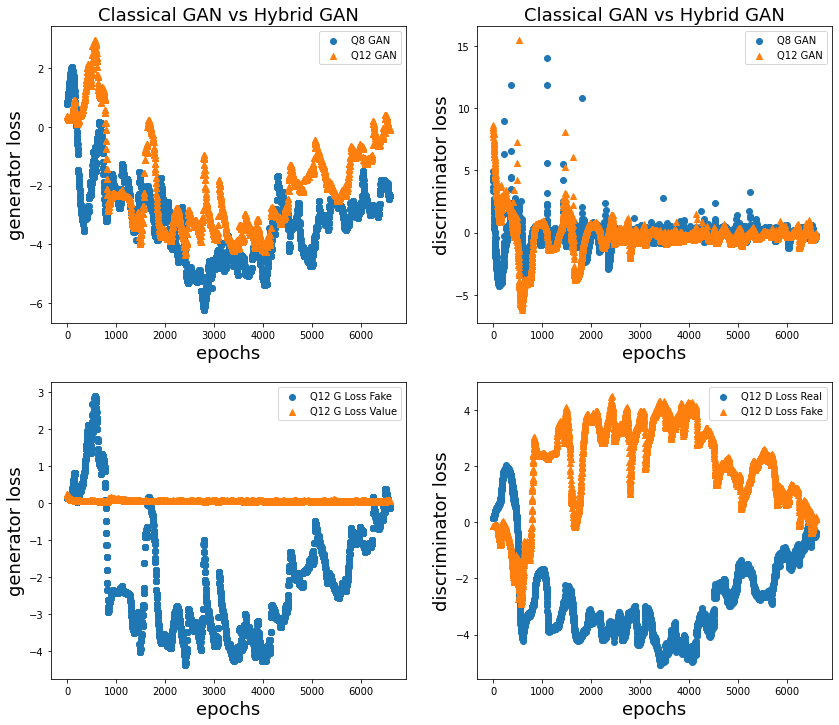

In [41]:
iters = 6619
shift = 20
fig = plt.subplots(2, 2, figsize=(14, 12))
plt.subplot(2, 2, 1)
plt.scatter(range(iters-shift), g_loss[shift:iters], marker='o', label='Q8 GAN')
plt.scatter(range(iters-shift), q12_g_loss[shift:iters], marker='^', label='Q12 GAN')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('generator loss', fontsize=18)
plt.title('Classical GAN vs Hybrid GAN', fontsize=18)
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(range(iters-shift), d_loss[shift:iters], marker='o', label='Q8 GAN')
plt.scatter(range(iters-shift), q12_d_loss[shift:iters], marker='^', label='Q12 GAN')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('discriminator loss', fontsize=18)
plt.title('Classical GAN vs Hybrid GAN', fontsize=18)
plt.legend()

plt.subplot(2, 2, 4)
plt.scatter(range(iters-shift), q12_d_loss_real[shift:iters], marker='o', label='Q12 D Loss Real')
plt.scatter(range(iters-shift), q12_d_loss_fake[shift:iters], marker='^', label='Q12 D Loss Fake')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('discriminator loss', fontsize=18)
# plt.title('Discriminator Loss', fontsize=18)
plt.legend()

plt.subplot(2, 2, 3)
plt.scatter(range(iters-shift), q12_g_loss_fake[shift:iters], marker='o', label='Q12 G Loss Fake')
plt.scatter(range(iters-shift), q12_g_loss_value[shift:iters], marker='^', label='Q12 G Loss Value')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('generator loss', fontsize=18)
# plt.title('Generator Loss', fontsize=18)
plt.legend()

In [44]:
# for 5 qubits
import csv
read_data = []
with open('metric_scores_5q.csv') as file:
    csv_reader = csv.reader(file, delimiter=',')
    next(csv_reader)
    for line in csv_reader:
        read_data.append(line)
        
gan_logp = [eval(read_data[i][10]) for i in range(len(read_data)) if read_data[i][10]!= 'nan']
gan_sa = [eval(read_data[i][11]) for i in range(len(read_data)) if read_data[i][11]!= 'nan']

q5_d_loss = [eval(read_data[i][2]) for i in range(len(read_data))]
q5_d_loss_fake = [eval(read_data[i][3]) for i in range(len(read_data))]
q5_d_loss_real = [eval(read_data[i][4]) for i in range(len(read_data))]
q5_g_loss = [eval(read_data[i][5]) for i in range(len(read_data))]
q5_g_loss_fake = [eval(read_data[i][6]) for i in range(len(read_data))]
q5_g_loss_value = [eval(read_data[i][7]) for i in range(len(read_data))]

In [45]:
len(q5_d_loss)

44536

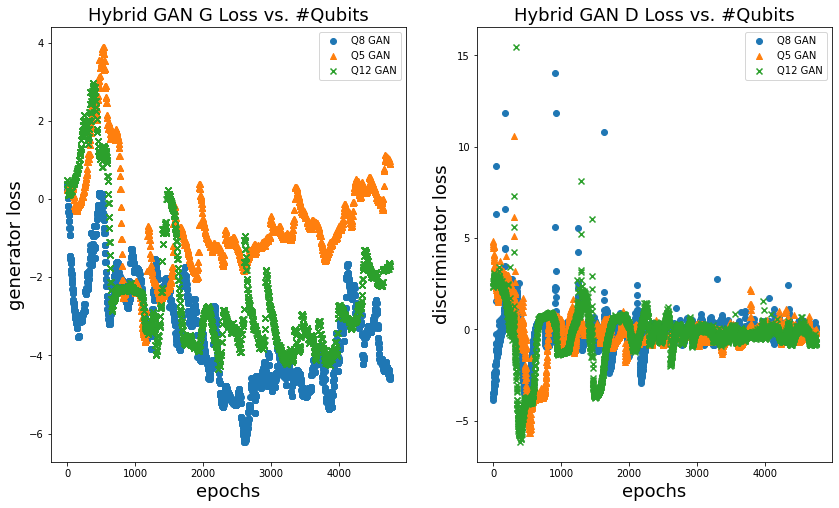

In [38]:
iters = 4953
shift = 200
fig = plt.subplots(1, 2, figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.scatter(range(iters-shift), g_loss[shift:iters], marker='o', label='Q8 GAN')
plt.scatter(range(iters-shift), q5_g_loss[shift:iters], marker='^', label='Q5 GAN')
plt.scatter(range(iters-shift), q12_g_loss[shift:iters], marker='x', label='Q12 GAN')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('generator loss', fontsize=18)
plt.title('Hybrid GAN G Loss vs. #Qubits', fontsize=18)
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(range(iters-shift), d_loss[shift:iters], marker='o', label='Q8 GAN')
plt.scatter(range(iters-shift), q5_d_loss[shift:iters], marker='^', label='Q5 GAN')
plt.scatter(range(iters-shift), q12_d_loss[shift:iters], marker='x', label='Q12 GAN')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('discriminator loss', fontsize=18)
plt.title('Hybrid GAN D Loss vs. #Qubits', fontsize=18)
plt.legend()

# plt.subplot(2, 2, 4)
# plt.scatter(range(iters-shift), q12_d_loss_real[shift:iters], marker='o', label='Q5 D Loss Real')
# plt.scatter(range(iters-shift), q12_d_loss_fake[shift:iters], marker='^', label='Q5 D Loss Fake')
# plt.xlabel('epochs', fontsize=18)
# plt.ylabel('discriminator loss', fontsize=18)
# # plt.title('Discriminator Loss', fontsize=18)
# plt.legend()

# plt.subplot(2, 2, 3)
# plt.scatter(range(iters-shift), q12_g_loss_fake[shift:iters], marker='o', label='Q5 G Loss Fake')
# plt.scatter(range(iters-shift), q12_g_loss_value[shift:iters], marker='^', label='Q5 G Loss Value')
# plt.xlabel('epochs', fontsize=18)
# plt.ylabel('generator loss', fontsize=18)
# # plt.title('Generator Loss', fontsize=18)
plt.legend()